<a href="https://colab.research.google.com/github/kangmg/xyzoverlay_ipython/blob/main/test_notebook/test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install -q ipympl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 14.8 MB/s eta 0:00:00


In [2]:
!wget -q https://raw.githubusercontent.com/kangmg/aimDIAS/main/examples/sn2.xyz -O sn2.xyz


In [3]:
import sys                                                      #sys.exit
import os.path                                                  #filename split
import argparse                                                 #argument parser
import pandas as pd                                             #pandas tables
import numpy as np                                              #calculations
from scipy.spatial.distance import pdist, squareform, cosine    #for the calculations of the distance matrix and angles (cosine)
import matplotlib.pyplot as plt                                 #for molecule display
from mpl_toolkits.mplot3d import Axes3D                         #for molecule display
from cycler import cycler                                       #generate color cycle
from itertools import cycle                                     #for color cycling
import io                                                       #IO for (easy) saving multi xyz
import re                                                       #regex (get atom x y z from multi xyz)

#var for check if xyz is multi xyz
# is_trj = 0 # 나중에 traj 세팅으로 넣어야 함

###### start view settings
#dpi for figure
plt.rcParams['savefig.dpi'] = 150

###### end view settings

In [4]:

#covalent radii from Alvarez (2008)
#DOI: 10.1039/b801115j
covalent_radii = {
    'H': 0.31, 'He': 0.28, 'Li': 1.28,
    'Be': 0.96, 'B': 0.84, 'C': 0.76,
    'N': 0.71, 'O': 0.66, 'F': 0.57, 'Ne': 0.58,
    'Na': 1.66, 'Mg': 1.41, 'Al': 1.21, 'Si': 1.11,
    'P': 1.07, 'S': 1.05, 'Cl': 1.02, 'Ar': 1.06,
    'K': 2.03, 'Ca': 1.76, 'Sc': 1.70, 'Ti': 1.60,
    'V': 1.53, 'Cr': 1.39, 'Mn': 1.61, 'Fe': 1.52,
    'Co': 1.50, 'Ni': 1.24, 'Cu': 1.32, 'Zn': 1.22,
    'Ga': 1.22, 'Ge': 1.20, 'As': 1.19, 'Se': 1.20,
    'Br': 1.20, 'Kr': 1.16, 'Rb': 2.20, 'Sr': 1.95,
    'Y': 1.90, 'Zr': 1.75, 'Nb': 1.64, 'Mo': 1.54,
    'Tc': 1.47, 'Ru': 1.46, 'Rh': 1.42, 'Pd': 1.39,
    'Ag': 1.45, 'Cd': 1.44, 'In': 1.42, 'Sn': 1.39,
    'Sb': 1.39, 'Te': 1.38, 'I': 1.39, 'Xe': 1.40,
    'Cs': 2.44, 'Ba': 2.15, 'La': 2.07, 'Ce': 2.04,
    'Pr': 2.03, 'Nd': 2.01, 'Pm': 1.99, 'Sm': 1.98,
    'Eu': 1.98, 'Gd': 1.96, 'Tb': 1.94, 'Dy': 1.92,
    'Ho': 1.92, 'Er': 1.89, 'Tm': 1.90, 'Yb': 1.87,
    'Lu': 1.87, 'Hf': 1.75, 'Ta': 1.70, 'W': 1.62,
    'Re': 1.51, 'Os': 1.44, 'Ir': 1.41, 'Pt': 1.36,
    'Au': 1.36, 'Hg': 1.32, 'Tl': 1.45, 'Pb': 1.46,
    'Bi': 1.48, 'Po': 1.40, 'At': 1.50, 'Rn': 1.50,
    'Fr': 2.60, 'Ra': 2.21, 'Ac': 2.15, 'Th': 2.06,
    'Pa': 2.00, 'U': 1.96, 'Np': 1.90, 'Pu': 1.87,
    'Am': 1.80, 'Cm': 1.69
}


# Ref. https://github.com/dralgroup/mlatom/blob/main/mlatom/data.py
periodic_table = """ X
  H                                                                                                                           He
  Li  Be                                                                                                  B   C   N   O   F   Ne
  Na  Mg                                                                                                  Al  Si  P   S   Cl  Ar
  K   Ca  Sc                                                          Ti  V   Cr  Mn  Fe  Co  Ni  Cu  Zn  Ga  Ge  As  Se  Br  Kr
  Rb  Sr  Y                                                           Zr  Nb  Mo  Tc  Ru  Rh  Pd  Ag  Cd  In  Sn  Sb  Te  I   Xe
  Cs  Ba  La  Ce  Pr  Nd  Pm  Sm  Eu  Gd  Tb  Dy  Ho  Er  Tm  Yb  Lu  Hf  Ta  W   Re  Os  Ir  Pt  Au  Hg  Tl  Pb  Bi  Po  At  Rn
  Fr  Ra  Ac  Th  Pa  U   Np  Pu  Am  Cm  Bk  Cf  Es  Fm  Md  No  Lr  Rf  Db  Sg  Bh  Hs  Mt  Ds  Rg  Cn  Nh  Fl  Mc  Lv  Ts  Og
""".strip().split()
atomic_number2element_symbol = {k: v for k, v in enumerate(periodic_table)}
element_symbol2atomic_number = {v: k for k, v in atomic_number2element_symbol.items()}

In [5]:
from numpy import ndarray
from mpl_toolkits.mplot3d import Axes3D


def set_axes_equal(ax)->Axes3D:
    """
    Description
    -----------
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc. This is one possible solution to Matplotlib's
    ax.set_aspect('equal') and ax.axis('equal') not working for 3D.

    Parameters
    ----------
    ax : Axes3D
        A Matplotlib 3D axis object.

    Note
    ----
    https://stackoverflow.com/questions/13685386/matplotlib-equal-unit-length-with-equal-aspect-ratio-z-axis-is-not-equal-to
    """
    # Get current limits of the axes
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    # Calculate ranges and midpoints for each axis
    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # Calculate the plot radius (half the max range, scaled)
    plot_radius = 0.35 * max([x_range, y_range, z_range])

    # Set new limits for each axis centered around the midpoints
    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])


def kabsch(P, Q):
    """
    Description
    -----------
    Compute the optimal rotation matrix using the Kabsch algorithm to align
    two sets of points P and Q.

    Parameters
    ----------
    P : ndarray
        An array of shape (N, 3) representing the first set of points.
    Q : ndarray
        An array of shape (N, 3) representing the second set of points.

    Returns
    -------
    ndarray
        A 3x3 rotation matrix.

    Note
    ----
    https://github.com/charnley/rmsd
    """
    # Compute the covariance matrix
    C = np.dot(np.transpose(P), Q)

    # Perform singular value decomposition
    V, S, W = np.linalg.svd(C)

    # Check if a reflection is needed
    d = (np.linalg.det(V) * np.linalg.det(W)) < 0.0
    if d:
        # Adjust the singular values and V matrix if reflection is needed
        S[-1] = -S[-1]
        V[:, -1] = -V[:, -1]

    # Compute the rotation matrix
    U = np.dot(V, W)

    return U


def align_xyz(vec1, vec2, coord)->ndarray:
    """
    Align a set of coordinates by computing the rotation matrix using the Kabsch
    algorithm with two reference vectors and applying it to the coordinates.

    Parameters
    ----------
    vec1 : ndarray
        An array of shape (N, 3) representing the first reference vector.
    vec2 : ndarray
        An array of shape (N, 3) representing the second reference vector.
    coord : ndarray
        An array of shape (M, 3) representing the coordinates to be aligned.

    Returns
    -------
    ndarray
        The aligned coordinates.
    """
    # Compute the rotation matrix using the Kabsch algorithm
    rotmatrix = kabsch(vec1, vec2)

    # Apply the rotation matrix to the coordinates
    return np.dot(coord, rotmatrix)

In [6]:
from os.path import isfile
import re
import numpy as np
from collections.abc import Iterable

def xyz_format_to_json(xyz_coord:str|dict)->dict:
    """
    Description
    -----------
    Converts xyz format coordinate(string or file) to json

    Parameters
    ----------
    xyz_coord : str or dict
        str : xyz format string or xyz format file path
        dict : {name: xyz format}

    Returns
    -------
    xyz_json : dict
        json format xyz
        {
            "name": str,
            "n_atoms": int,
            "coordinate": ndarray
        }

    Usage
    -----
    >>> molecule = {
    >>>   'name': 'aspirin',
    >>>   'coordinate': '''
    >>>   2
    >>>
    >>>   H 0.0 0.0 0.7
    >>>   H 0.0 0.0 0.0
    >>>   '''
    >>>     }
    >>> xyz_json = xyz_format_to_json(molecule)


    """
    # read xyz file
    if isinstance(xyz_coord, dict):
        name = xyz_coord["name"]
        xyz_string = xyz_coord["coordinate"]

    if isinstance(xyz_coord, str):
        if isfile(xyz_coord):
            # xyz string
            with open(xyz_coord, "r") as file:
                xyz_string = file.read()
            # name
            name = os.path.basename(xyz_coord)
        else:
            name = ''
            xyz_string = xyz_coord

    # number of atoms
    n_atoms = re.search(r"(\d+)", xyz_string).group(0)

    # split xyz string
    pattern = re.compile("([a-zA-Z]{1,2}(\s+-?\d+.\d+){3,3})+")
    xyz_lines = np.array(np.array(list(re.split(r'\s+', tup[0]) for tup in pattern.findall(xyz_string))))

    # converts atomic_symbol to atomic_number
    xyz_lines[:, 0] = np.array(list(element_symbol2atomic_number[symbol] for symbol in xyz_lines[:, 0]))

    # json format xyz
    xyz_json = {
        "name": name,
        "n_atoms": n_atoms,
        "coordinate": xyz_lines.astype(float)
    }

    return xyz_json



def open_xyz_files(xyz_coordinates:str|list)->list:
    """
    Description
    -----------
    Open and read XYZ files, extract headers and atomic coordinates.

    Parameters
    ----------
    filenames : str or list
        str : xyz format traj file path
        list : list of xyz format file path

    Returns
    -------
    xyz_format_jsons : list
        list of json format xyz
    """
    # traj file
    if isinstance(xyz_coordinates, str):
        with open(xyz_coordinates, "r") as file:
            traj_string = file.read()
        # find all xyz format strings
        pattern = re.compile("(\s?\d+\n.*\n(\s*[a-zA-Z]{1,2}(\s+-?\d+.\d+){3,3}\n?)+)")
        matched_xyz_formats = pattern.findall(traj_string)
        xyz_format_strings = list(tup[0] for tup in matched_xyz_formats)

        # convert xyz format stirng to json format
        xyz_format_jsons = list(map(xyz_format_to_json, xyz_format_strings))

        return xyz_format_jsons

    elif isinstance(xyz_coordinates, Iterable):
        return list(map(xyz_format_to_json, xyz_coordinates))

    else:
        raise TypeError("xyz_coordinates must be str or list")

> parameters
```
[#] filename: (필수) 하나 이상의 XYZ 파일 이름을 입력받습니다.
[#] -a, --atoms: 분자 정렬을 위해 선택할 원자들을 지정합니다. 여러 그룹의 원자를 지정할 수 있습니다.
[#] -sa, --sameatoms: 모든 XYZ 파일에서 동일한 원자들을 선택하여 정렬에 사용합니다.
[#] -aa, --allatoms: 모든 원자를 정렬에 사용합니다. XYZ 파일들의 원자 수가 동일해야 합니다.
[ ] -vca, --viewcba: 원자 종류별로 색을 다르게 하여 분자를 시각화합니다.
[ ] -vcm, --viewcbm: 분자별로 색을 다르게 하여 시각화합니다.
[ ] -cm, --cmap: Matplotlib의 컬러맵을 사용하여 시각화합니다.
[ ] -r, --radius: 시각화 시 원자 반지름을 지정된 비율만큼 확대합니다 (기본값 8%).
[ ] -ee, --excludeEl: 시각화에서 제외할 원소들을 지정합니다.
[ ] -ea, --excludeAt: 시각화에서 제외할 원자들을 지정합니다.
[ ] -st, --savetr: 정렬된 데이터를 하나의 (다중) XYZ 파일 또는 XYZ 궤적 파일로 저장합니다.
```

In [7]:
from collections.abc import Iterable
from copy import deepcopy

def superimpose(xyz_format_jsons:list, option="aa", option_param:None|list=None)->dict:
    """
    Description
    -----------
    Superimpose molecules

    Parameters
    ----------
    option : str
        supported options : ["aa", "a", "sa"]
        - aa  : all atoms
        - a   : atoms
        - sa  : same atoms

    option_param : list
        list of atom index to superimpose
        index starts with 1
        - option="aa"   : None
        - option="a"    : e.g. [[1, 2, 3], [4, 5, 6]] # same order as xyz files
        - option="sa"   : e.g. [1, 2, 3]
    """
    # copy xyz_format_jsons
    _xyz_format_jsons = deepcopy(xyz_format_jsons)

    # all atoms ( -aa option )
    if option=="aa":
        if option_param: print("\033[31m[WARNING]\033[0m", "`aa` option does not require `option_param`. `option_param` is ignored.")

        # `aa` option expects that each coordinates has the same order of atoms
        atomic_indice_list = list(map(lambda xyz_json : xyz_json.get("coordinate")[:, 0], _xyz_format_jsons))
        symbols_list = list(atomic_number2element_symbol[atomic_index[0]] for atomic_index in atomic_indice_list)
        # check each coordinates has same order
        if not np.all(np.array(symbols_list) == symbols_list[0]):
            raise ValueError("The `aa` option expects that each coordinates has the same order of atoms. \n Try other options like `sa` or `a`")

        # every molecule is overlaid on the first molecule
        first_molecule = _xyz_format_jsons[0]["coordinate"][:, 1:]
        centroid = np.mean(first_molecule, axis=0)

        # center the first(reference) molecule
        first_molecule -= centroid
        _xyz_format_jsons[0]["coordinate"][:, 1:] = first_molecule

        for mol_idx in range(len(_xyz_format_jsons)):
            # center the molecule
            centroid_mol = np.mean(_xyz_format_jsons[mol_idx]["coordinate"][:, 1:], axis=0)
            _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] -= centroid_mol

            # overlay each molecule on the first molecule
            _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] = align_xyz(
                vec1=_xyz_format_jsons[mol_idx]["coordinate"][:, 1:], # molecule to align
                vec2=first_molecule, # reference molecule
                coord=_xyz_format_jsons[mol_idx]["coordinate"][:, 1:] # coordinates to align
              )

    # atoms ( -a option )
    elif option=="a":
        # `option_param` should be a list with the same size as the number of molecules to overlay
        if not option_param: raise ValueError("`a` option requires `option_param`")
        if not isinstance(option_param, Iterable): raise TypeError("`option_param` must be list")
        if not np.all(np.array(list(len(param) for param in option_param)) == len(option_param[0])): raise ValueError("all elements in `option_param` must have the same size")
        if not len(_xyz_format_jsons) == len(option_param): raise ValueError(f"""`a` option requires `option_param` to have the same length as `xyz_format_jsons`\n
         Number of molecules to overlay : {len(_xyz_format_jsons)}
         Length of option_param : {len(option_param)}""")
        if any(list((0 in param) for param in option_param)): raise ValueError("atomic indices start with 1, but 0 was found in `option_param`")

        # reset atomic indice
        option_param = list(
            list(param - 1 for param in mol_param) for mol_param in option_param
            )

        # every molecule is overlaid on the first molecule
        first_molecule_selected_atoms = _xyz_format_jsons[0]["coordinate"][:, 1:][[option_param[0]]][0]
        centroid = np.mean(first_molecule_selected_atoms, axis=0)

        # center the first(reference) molecule
        _xyz_format_jsons[0]["coordinate"][:, 1:] -= centroid

        for mol_idx in range(len(_xyz_format_jsons)):
            # center the molecule
            centroid_mol = np.mean(_xyz_format_jsons[mol_idx]["coordinate"][:, 1:][[option_param[mol_idx]]], axis=0)
            _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] -= centroid_mol

            # overlay each molecule on the first molecule
            _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] = align_xyz(
                vec1=_xyz_format_jsons[mol_idx]["coordinate"][:, 1:][[option_param[mol_idx]]][0], # molecule to align
                vec2=first_molecule_selected_atoms,
                coord=_xyz_format_jsons[mol_idx]["coordinate"][:, 1:] # coordinates to align
              )

    # same atom ( -sa option )
    elif option=="sa":
        # `option_param` should be a list
        if not option_param: raise ValueError("`sa` option requires `option_param`")
        if not isinstance(option_param, Iterable): raise TypeError("`option_param` must be list")
        if 0 in option_param: raise ValueError("atomic indices start with 1, but 0 was found in `option_param`")

        # `sa` option expects that each coordinates has the same order of selected atoms
        selected_atomic_indice_list = list(map(lambda xyz_json : xyz_json.get("coordinate")[:, 0][[option_param]], _xyz_format_jsons))
        selected_symbols_list = list(atomic_number2element_symbol[atomic_number[0][0]] for atomic_number in selected_atomic_indice_list)

        # check each coordinates has same order
        if not np.all(np.array(selected_symbols_list) == selected_symbols_list[0]):
            raise ValueError("The `aa` option expects that each coordinates has the same order of atoms. \n Try other options like `sa` or `a`")

        # reset atomic indice
        option_param = list(param - 1 for param in option_param)

        # every molecule is overlaid on the first molecule
        first_molecule_selected_atoms = _xyz_format_jsons[0]["coordinate"][:, 1:][[option_param]][0]
        centroid = np.mean(first_molecule_selected_atoms, axis=0)

        # center the first(reference) molecule
        _xyz_format_jsons[0]["coordinate"][:, 1:] -= centroid

        for mol_idx in range(len(_xyz_format_jsons)):
            # center the molecule
            centroid_mol = np.mean(_xyz_format_jsons[mol_idx]["coordinate"][:, 1:][[option_param]], axis=0)
            _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] -= centroid_mol
            # overlay each molecule on the first molecule
            _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] = align_xyz(
                vec1=_xyz_format_jsons[mol_idx]["coordinate"][:, 1:][[option_param]][0], # molecule to align
                vec2=first_molecule_selected_atoms,
                coord=_xyz_format_jsons[mol_idx]["coordinate"][:, 1:] # coordinates to align
              )

    else:
        raise ValueError(f"Unsupported option : {option}")

    return _xyz_format_jsons



In [21]:
import matplotlib.pyplot as plt
from copy import deepcopy
#from cycler import cycler
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D

def visualize_molecules(xyz_format_jsons:list, colorby:str="molecule", exclude_elements:list=None, exclude_atomic_idx:list=None, cmap:str=None, covalent_radius_percent:float=108., **kwargs):
    """
    Description
    -----------

    Parameters
    ----------
    - xyz_format_jsons : list
        list of json format xyz

    - colorpy : str
        supported options : ["molecule", "atom"]
        - molecule  : color by molecule
        - atom      : color by atom

    - exclude_elements : list
        list of elements to exclude from visualization. e.g. ["H"]

    - exclude_atomic_idx : list
        list of atoms to exclude from visualization. e.g. [1, 3, 4]

    - cmap : str
        Matplotlib colormap to use for coloring.
        Supported options : [ 'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                              'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu', 'GnBu',
                              'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn', etc . . . ]
        Refer)
        https://matplotlib.org/stable/users/explain/colors/colormaps.html

    - covalent_radius_percent : float
        resize covalent radii by this percent
        default : 108%

    Returns
    -------
    """
    def _covalent_radii(element:str, percent:float):
        """resize covalent radii
        """
        radius = covalent_radii[element]
        radius = (radius * (percent / 100))
        return radius

    # set default values
    alpha_atoms = kwargs.get("alpha_atom") if kwargs.get("alpha_atom") else 0.55 # atoms opacity
    alpha_bonds = kwargs.get("alpha_bond") if kwargs.get("alpha_bond") else 0.55 # bonds opacity
    atom_scaler = kwargs.get("atom_scaler") if kwargs.get("atom_scaler") else 1e60 # sphere radius for atom view, change exponent
    bond_scaler = kwargs.get("bond_scaler") if kwargs.get("bond_scaler") else 1e6 # cylinder radius for bond view, change exponent

    # copy xyz_format_jsons
    _xyz_format_jsons = deepcopy(xyz_format_jsons)

    # plt figure setting
    fig = plt.figure(figsize=(10,8))
    ax = plt.axes(projection='3d')
    ax.set_box_aspect((1, 1, 1))

    # exclude atoms
    if exclude_atomic_idx:
        # `exclude_atomic_idx` option expects that each coordinates has the same order of atoms
        symbols_list = list(map(lambda xyz_json : xyz_json.get("coordinate")[:, 0], _xyz_format_jsons))
        if not np.all(np.array(symbols_list) == symbols_list[0]):
            print("\033[31m[WARNING]\033[0m", "`exclude_atomic_idx` option expects that each coordinates has the same order of atoms")
        # atomic indice start with 1
        if 0 in exclude_atomic_idx: raise ValueError("atomic indices start with 1, but 0 was found in `exclude_atomic_idx`")

        # reset atomic indice
        exclude_atomic_idx = list(idx - 1 for idx in exclude_atomic_idx)

        # check if atomic index is out of range
        if any(max(exclude_atomic_idx) > len(_xyz_format_jsons[mol_idx]["coordinate"]) for mol_idx in range(len(_xyz_format_jsons))):
            raise ValueError(f"Atomic index {max(exclude_atomic_idx)} provided in `exclude_atomic_idx` is out of range in your molecule.")

        for mol_idx in range(len(_xyz_format_jsons)):
            # filter the atom in `exclude_atomic_idx`
            atom_filtered_coordinate = list(
                atomic_coordinate for atomic_idx, atomic_coordinate in enumerate(_xyz_format_jsons[mol_idx]["coordinate"]) if atomic_idx not in exclude_atomic_idx
                  )
            # overwrite filtered coordinate
            _xyz_format_jsons[mol_idx]["coordinate"] = atom_filtered_coordinate
            # adjust number of atoms : n_atoms
            _xyz_format_jsons[mol_idx]["n_atoms"] = len(atom_filtered_coordinate)

    # exclude elements
    if exclude_elements:
        for mol_idx in range(len(_xyz_format_jsons)):
            # filter the element in `exclude_elements`
            element_filtered_coordinate = list(
                atomic_coordinate for atomic_coordinate in _xyz_format_jsons[mol_idx]["coordinate"] if atomic_number2element_symbol[atomic_coordinate[0]] not in exclude_elements
                  )
            # overwrite filtered coordinate
            _xyz_format_jsons[mol_idx]["coordinate"] = element_filtered_coordinate
            # adjust number of atoms : n_atoms
            _xyz_format_jsons[mol_idx]["n_atoms"] = len(element_filtered_coordinate)

    if colorby=="molecule":
        # number of molecules
        num_of_xyz = len(_xyz_format_jsons)
        # max number of atoms
        num_atom_xyz = max(len(xyz_jsons["coordinate"]) for xyz_jsons in _xyz_format_jsons)
        # num_atom_xyz = max(len(xyz_df) for xyz_df in xyz_df_list) # original code

        # use matplotlib colormap
        if cmap:
            try:
                # get color palette
                palette = list(plt.get_cmap(cmap)(ratio) for ratio in np.linspace(0, 1, num_of_xyz+1)[1:])
                color_cycle = cycle(palette)
            except ValueError:
                print("\033[31m[WARNING]\033[0m", f"`{cmap}` is not a valid matplotlib colormap. Applying default colormap instead.")
        else:
            color_cycle = cycle(['b', 'r', 'g', 'c', 'm', 'y'])

        # get molecular connetivity & bond length
        for mol_idx in range(len(_xyz_format_jsons)):
            # get interatomic distance(L2 norm) matrix
            atomic_coordinates = _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] # (N, 3)
            L2_matrix = squareform(pdist(atomic_coordinates, 'euclidean')) # (N, N)

            # get sum of atomic radii matrix
            symbols_vector = np.array(list(
                atomic_number2element_symbol[atomic_number] for atomic_number in _xyz_format_jsons[mol_idx]["coordinate"][:, 0]
                  )) # (N, 3)
            radii_vector = np.array(list(_covalent_radii(symbol, covalent_radius_percent) for symbol in symbols_vector)) # (N, 3)
            radii_sum_matrix = np.add.outer(radii_vector, radii_vector) # (N, N)

            # get adjacency(bond) matrix
            adjacency_matrix = np.array(L2_matrix <= radii_sum_matrix) # (N, N)
            np.fill_diagonal(adjacency_matrix, 0) # diagonal means self-bonding
            _xyz_format_jsons[mol_idx]["adjacency_matrix"] = adjacency_matrix

            # bond length matrix = adjacency_matrix * L2_matrix
            bond_length_matrix = adjacency_matrix * L2_matrix # (N, N)

            # get bond length table
            # remove duplicated values. Rba = Rab ( symmetrix mat. )
            bond_length_matrix[np.triu_indices_from(bond_length_matrix, k=1)] = 0
            mask = ~np.equal(bond_length_matrix, 0)
            # bond ( atom_pair ) & bond length
            atom_pairs = np.array(np.nonzero(mask)).T
            length = bond_length_matrix[mask]
            # bond length table ["atom_1_idx", "atom_2_idx", "distance"] # idx start with 1
            #atom_1 = symbols_vector[atom_pairs[:, 0]]
            #atom_2 = symbols_vector[atom_pairs[:, 1]]
            #bond_length_table = np.column_stack((atom_1, atom_2, length))
            bond_length_table = np.column_stack((atom_pairs[:, 0] + 1, atom_pairs[:, 1] + 1, length))
            _xyz_format_jsons[mol_idx]["bond_length_table"] = bond_length_table

        # plot atoms & bonds
        for mol_idx in range(len(_xyz_format_jsons)):
            color = next(color_cycle)
            # plot atoms
            ax.scatter(*_xyz_format_jsons[mol_idx]["coordinate"][:, 1:].T, s=np.log10(atom_scaler/num_atom_xyz),alpha=alpha_atoms,c=color)

            # plot bonds
            bonds = _xyz_format_jsons[mol_idx]["bond_length_table"][:, :2]
            for bond in bonds:
                bond = bond.astype(int) - 1 # internally idx start with 0
                # convert symbol to atomic nubmer
                atom_1_coord = _xyz_format_jsons[mol_idx]["coordinate"][:, 1:][bond[0]]
                atom_2_coord = _xyz_format_jsons[mol_idx]["coordinate"][:, 1:][bond[1]]
                ax.plot(*np.array([atom_1_coord, atom_2_coord]).T, linewidth=np.log10(bond_scaler/num_atom_xyz), alpha=alpha_bonds, c=color)

        #no axes
        ax.set_axis_off()
        #tight layout
        fig.tight_layout()
        #adjust 3d drawing behavior, otherwise molecules are not correctly displayes
        set_axes_equal(ax)
        #show the plot
        plt.show()


    elif colorby=="atom":
        #assign elements to colors
        metals = ['Ac', 'Ag', 'Al', 'Am', 'Ar', 'As', 'At', 'Au', 'Ba', 'Be', \
                    'Bi', 'Ca', 'Cd', 'Ce', 'Cf', 'Cm', 'Co', 'Cr', 'Cs', 'Cu', \
                    'Db', 'Dy', 'Er', 'Es', 'Eu', 'Fe', 'Fm', 'Fr', 'Ga', 'Gd', \
                    'Ge', 'Hf', 'Hg', 'Ho', 'Hs', 'In', 'Ir', 'K', 'La', 'Li', \
                    'Lr', 'Lu', 'Md', 'Mg', 'Mn', 'Mo', 'Na', 'Nb', 'Nd', 'Ni', \
                    'Np', 'Os', 'Pa', 'Pb', 'Pd', 'Pm', 'Po', 'Pr', 'Pt', 'Pu', \
                    'Ra', 'Rb', 'Re', 'Rf', 'Rh', 'Rn', 'Ru', 'Sc', 'Sm', 'Sn', \
                    'Sr', 'Ta', 'Tb', 'Tc', 'Te', 'Th', 'Ti', 'Tl', 'Tm', 'U', \
                    'V', 'W', 'Y', 'Yb', 'Zn', 'Zr']
        green = ['F','Cl']
        brown = ['Br']
        purple = ['P','I']
        orange = ['Si']

    else:
        raise ValueError(f"Unsupported option : {colorby}")



# TODO

# add residual atoms color map likes B, Li, Na etc
# https://en.wikipedia.org/wiki/CPK_coloring

In [9]:
from google.colab import output
output.enable_custom_widget_manager()

<ipython-input-21-52d5b7391bed>:159: UserWarning:

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.



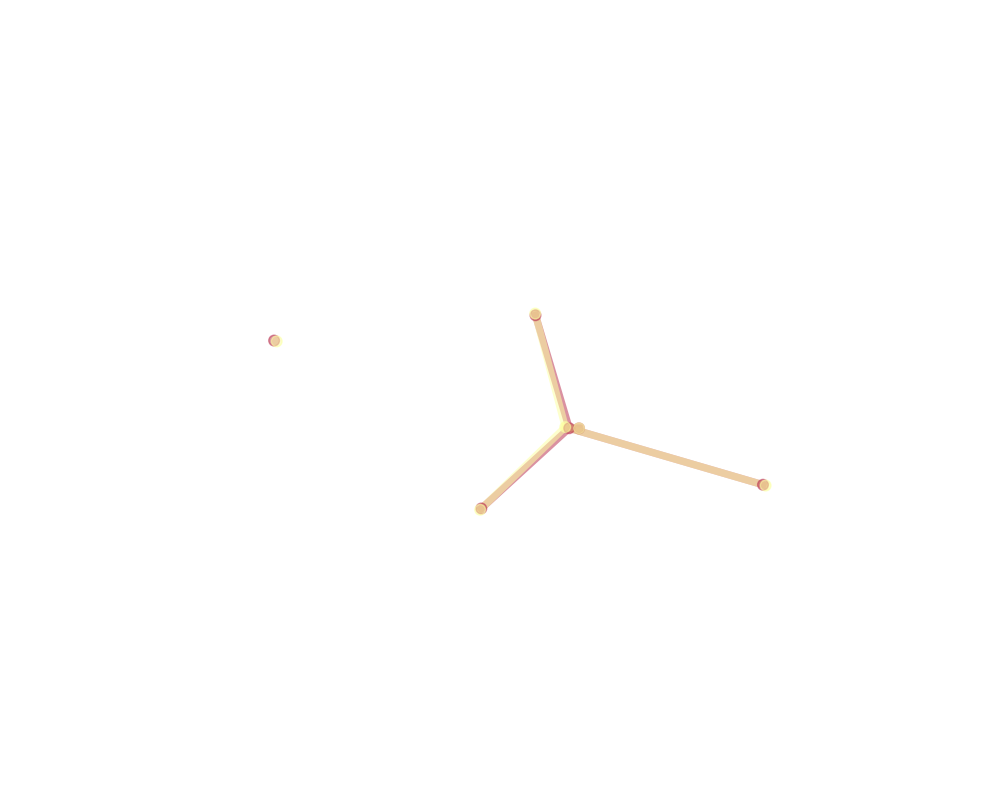

In [22]:
%matplotlib widget

jsons = open_xyz_files("tmp.xyz")
superimposed_jsons = superimpose(jsons, option="aa")
visualize_molecules(superimposed_jsons, cmap="inferno")

In [56]:
import plotly.colors as pc

def get_colorscale_colors(colorscale_name, n):
    """
    Plotly 색상 스케일에서 n 개의 색상을 추출합니다.

    Parameters:
    colorscale_name (str): Plotly 색상 스케일 이름 (예: 'Viridis', 'Cividis', 'Inferno' 등).
    n (int): 추출할 색상 수.

    Returns:
    list: 색상 값 리스트.
    """
    colorscale = pc.get_colorscale(colorscale_name)
    colors = pc.sample_colorscale(colorscale, [i / (n - 1) for i in range(n)], colortype='rgb')
    return colors

# 예시 사용법
colors = get_colorscale_colors('Viridis', 10)
print(colors)

len(colors)



['rgb(68, 1, 84)', 'rgb(72, 40, 120)', 'rgb(62, 73, 137)', 'rgb(49, 104, 142)', 'rgb(38, 130, 142)', 'rgb(31, 158, 137)', 'rgb(53, 183, 121)', 'rgb(110, 206, 88)', 'rgb(181, 222, 43)', 'rgb(253, 231, 37)']


10

In [57]:
import plotly.colors as pc
import numpy as np

def _get_colors(camp:str, n):
    """get n size color list from plotly colormap
    """
    try:
        colors = pc.get_colorscale(camp)
    except ValueError:
        print("\033[31m[WARNING]\033[0m", f"`{camp}` is not a valid plotly colormap. Applying default colormap instead.")
        colors = pc.get_colorscale('Plotly3')
    return list(pc.sample_colorscale(colors, list(ratio for ratio in np.linspace(0, 1, n+1)[1:]), colortype='rgb'))


# 예시 사용법
colors = _get_colors('Viridis', 10)
print(colors)

['rgb(72, 36, 116)', 'rgb(64, 66, 134)', 'rgb(53, 95, 140)', 'rgb(42, 120, 142)', 'rgb(34, 144, 140)', 'rgb(40, 168, 131)', 'rgb(70, 190, 111)', 'rgb(124, 209, 79)', 'rgb(188, 223, 42)', 'rgb(253, 231, 37)']


In [77]:
# plotly

import plotly.graph_objects as go
import numpy as np
from copy import deepcopy
from scipy.spatial.distance import pdist, squareform

def visualize_molecules(xyz_format_jsons:list, colorby:str="molecule", exclude_elements:list=None, exclude_atomic_idx:list=None, cmap:str=None, covalent_radius_percent:float=108., **kwargs):
    """
    Description
    -----------
    Visualization of molecular structures in 3D using Plotly.

    Parameters
    ----------
    - xyz_format_jsons : list
        list of json format xyz

    - colorby : str
        supported options : ["molecule", "atom"]
        - molecule  : color by molecule
        - atom      : color by atom

    - exclude_elements : list
        list of elements to exclude from visualization. e.g. ["H"]

    - exclude_atomic_idx : list
        list of atoms to exclude from visualization. e.g. [1, 3, 4]

    - cmap : str
        Matplotlib colormap to use for coloring.
        Supported options : [  ]
        Refer)
        https://matplotlib.org/stable/users/explain/colors/colormaps.html

    - covalent_radius_percent : float
        resize covalent radii by this percent
        default : 108%

    Returns
    -------
    """
    def _covalent_radii(element:str, percent:float):
        """resize covalent radii"""
        radius = covalent_radii[element]
        radius = (radius * (percent / 100))
        return radius

    def _get_colors(camp:str, n):
        """get n size color list from plotly colormap
        """
        try:
            colors = pc.get_colorscale(camp)
        except Exception:
            print("\033[31m[WARNING]\033[0m", f"`{camp}` is not a valid plotly colormap. Applying default colormap instead.")
            colors = pc.get_colorscale('Plotly3')
        return list(pc.sample_colorscale(colors, list(ratio for ratio in np.linspace(0, 1, n+1)[1:]), colortype='rgb'))

    # set default values
    alpha_atoms = kwargs.get("alpha_atom") if kwargs.get("alpha_atom") else 0.55 # atoms opacity
    alpha_bonds = kwargs.get("alpha_bond") if kwargs.get("alpha_bond") else 0.55 # bonds opacity
    #atom_scaler = kwargs.get("atom_scaler") if kwargs.get("atom_scaler") else 1e60 # sphere radius for atom view, change exponent
    atom_scaler = kwargs.get("atom_scaler") if kwargs.get("atom_scaler") else 2e1 # sphere radius for atom view, change exponent
    #bond_scaler = kwargs.get("bond_scaler") if kwargs.get("bond_scaler") else 1e6 # cylinder radius for bond view, change exponent
    bond_scaler = kwargs.get("bond_scaler") if kwargs.get("bond_scaler") else 1e4 # cylinder radius for bond view, change exponent

    # copy xyz_format_jsons
    _xyz_format_jsons = deepcopy(xyz_format_jsons)

    # Plotly figure setting
    fig = go.Figure()

    # exclude atoms
    if exclude_atomic_idx:
        symbols_list = list(map(lambda xyz_json : xyz_json.get("coordinate")[:, 0], _xyz_format_jsons))
        if not np.all(np.array(symbols_list) == symbols_list[0]):
            print("\033[31m[WARNING]\033[0m", "`exclude_atomic_idx` option expects that each coordinates has the same order of atoms")
        if 0 in exclude_atomic_idx: raise ValueError("atomic indices start with 1, but 0 was found in `exclude_atomic_idx`")

        exclude_atomic_idx = list(idx - 1 for idx in exclude_atomic_idx)

        if any(max(exclude_atomic_idx) > len(_xyz_format_jsons[mol_idx]["coordinate"]) for mol_idx in range(len(_xyz_format_jsons))):
            raise ValueError(f"Atomic index {max(exclude_atomic_idx)} provided in `exclude_atomic_idx` is out of range in your molecule.")

        for mol_idx in range(len(_xyz_format_jsons)):
            atom_filtered_coordinate = list(
                atomic_coordinate for atomic_idx, atomic_coordinate in enumerate(_xyz_format_jsons[mol_idx]["coordinate"]) if atomic_idx not in exclude_atomic_idx
                  )
            _xyz_format_jsons[mol_idx]["coordinate"] = atom_filtered_coordinate
            _xyz_format_jsons[mol_idx]["n_atoms"] = len(atom_filtered_coordinate)

    if exclude_elements:
        for mol_idx in range(len(_xyz_format_jsons)):
            element_filtered_coordinate = list(
                atomic_coordinate for atomic_coordinate in _xyz_format_jsons[mol_idx]["coordinate"] if atomic_number2element_symbol[atomic_coordinate[0]] not in exclude_elements
                  )
            _xyz_format_jsons[mol_idx]["coordinate"] = element_filtered_coordinate
            _xyz_format_jsons[mol_idx]["n_atoms"] = len(element_filtered_coordinate)

    if colorby == "molecule":
        num_of_xyz = len(_xyz_format_jsons)
        num_atom_xyz = max(len(xyz_jsons["coordinate"]) for xyz_jsons in _xyz_format_jsons)

        if cmap:
            palette = _get_colors(cmap, num_of_xyz)
        # # use matplotlib colormap (convert to Plotly colors)
        # if cmap:
        #     try:
        #         import matplotlib.pyplot as plt
        #         import matplotlib.cm as cm
        #         palette = [cm.get_cmap(cmap)(i / num_of_xyz) for i in range(num_of_xyz)]
        #         palette = [f'rgb({int(c[0]*255)},{int(c[1]*255)},{int(c[2]*255)})' for c in palette]
        #     except ValueError:
        #         print("\033[31m[WARNING]\033[0m", f"`{cmap}` is not a valid matplotlib colormap. Applying default colormap instead.")
        #         palette = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow']
        # else:
        #     palette = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow']

        for mol_idx in range(len(_xyz_format_jsons)):
            color = palette[mol_idx]

            atomic_coordinates = _xyz_format_jsons[mol_idx]["coordinate"][:, 1:] # (N, 3)
            L2_matrix = squareform(pdist(atomic_coordinates, 'euclidean')) # (N, N)

            symbols_vector = np.array(list(
                atomic_number2element_symbol[atomic_number] for atomic_number in _xyz_format_jsons[mol_idx]["coordinate"][:, 0]
                  )) # (N, 3)
            radii_vector = np.array(list(_covalent_radii(symbol, covalent_radius_percent) for symbol in symbols_vector)) # (N, 3)
            radii_sum_matrix = np.add.outer(radii_vector, radii_vector) # (N, N)

            adjacency_matrix = np.array(L2_matrix <= radii_sum_matrix) # (N, N)
            np.fill_diagonal(adjacency_matrix, 0) # diagonal means self-bonding
            _xyz_format_jsons[mol_idx]["adjacency_matrix"] = adjacency_matrix

            bond_length_matrix = adjacency_matrix * L2_matrix # (N, N)

            bond_length_matrix[np.triu_indices_from(bond_length_matrix, k=1)] = 0
            mask = ~np.equal(bond_length_matrix, 0)
            atom_pairs = np.array(np.nonzero(mask)).T
            length = bond_length_matrix[mask]
            bond_length_table = np.column_stack((atom_pairs[:, 0] + 1, atom_pairs[:, 1] + 1, length))
            _xyz_format_jsons[mol_idx]["bond_length_table"] = bond_length_table

            # Add atoms to plot
            atom_size = np.maximum(np.log10(atom_scaler / num_atom_xyz) * 5, 2)
            fig.add_trace(go.Scatter3d(
                x=_xyz_format_jsons[mol_idx]["coordinate"][:, 1],
                y=_xyz_format_jsons[mol_idx]["coordinate"][:, 2],
                z=_xyz_format_jsons[mol_idx]["coordinate"][:, 3],
                mode='markers',
                marker=dict(size=atom_size, color=color, opacity=alpha_atoms),
                name=f"Molecule {mol_idx}"
            ))

            # Add bonds to plot
            bonds = _xyz_format_jsons[mol_idx]["bond_length_table"][:, :2]
            bond_thickness = np.maximum(np.log10(bond_scaler / num_atom_xyz) * 2, 1)
            for bond in bonds:
                bond = bond.astype(int) - 1
                atom_1_coord = _xyz_format_jsons[mol_idx]["coordinate"][:, 1:][bond[0]]
                atom_2_coord = _xyz_format_jsons[mol_idx]["coordinate"][:, 1:][bond[1]]
                fig.add_trace(go.Scatter3d(
                    x=[atom_1_coord[0], atom_2_coord[0]],
                    y=[atom_1_coord[1], atom_2_coord[1]],
                    z=[atom_1_coord[2], atom_2_coord[2]],
                    mode='lines',
                    line=dict(width=bond_thickness, color=color),  # Removed opacity
                    name=f"Bond {mol_idx}-{bond[0]+1}-{bond[1]+1}"
                ))

    # Adjust layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='data',
            camera_projection=dict(type='orthographic'),
            #aspectratio=dict(x=1, y=1, z=1)
        ),
        showlegend=False
    )

    fig.show()


In [81]:
jsons = open_xyz_files("wittig.xyz")
superimposed_jsons = superimpose(jsons, option="aa")
visualize_molecules(superimposed_jsons, cmap="Plotly3")

jsons = open_xyz_files("sn2.xyz")
superimposed_jsons = superimpose(jsons, option="aa")
visualize_molecules(superimposed_jsons, cmap="Turbo")

In [80]:
jsons = open_xyz_files("sn2.xyz")
superimposed_jsons = superimpose(jsons, option="aa")
visualize_molecules(superimposed_jsons, cmap="Turbo")

> Test molecules

In [13]:
%%writefile xyz1.xyz
6
 0.000000
  C -1.277168 0.545365 -0.000063
  Br 0.648058 0.543727 0.000199
  H -1.652166 0.593222 1.017641
  H -1.652215 -0.359651 -0.467952
  H -1.651698 1.403205 -0.550042
  Cl -4.402752 0.572053 0.000227

Writing xyz1.xyz


In [14]:
%%writefile xyz2.xyz
6
 0.000000
  C -1.294919 0.542959 5.001299
  Br 0.694616 0.543808 4.999562
  H -1.636980 0.598072 6.030309
  H -1.637355 -0.369230 4.522183
  H -1.633737 1.408958 4.446127
  Cl -4.352783 0.570770 5.000338

Writing xyz2.xyz


In [15]:
!cat xyz1.xyz xyz2.xyz > tmp.xyz

In [27]:
%%writefile wittig.xyz
47
0 1 0.059778
C       -1.4508270       -1.7370320        1.0369570
C       -1.2372390       -1.2421820        2.4697700
O       -0.3027010       -0.1547390        2.1731120
P       -0.1751230       -0.2888580        0.4773510
H       -0.6927520       -1.9737940        3.0798710
C       -1.3216410        0.5900230       -0.7103560
C       -1.4162490        0.3165370       -2.0824370
C       -2.1648680        1.5701020       -0.1596710
C       -2.3333230        1.0073740       -2.8836110
H       -0.7716640       -0.4229150       -2.5454140
C       -3.0866580        2.2523190       -0.9577610
H       -2.1024980        1.8116030        0.8985790
C       -3.1754490        1.9722170       -2.3250430
H       -2.3846140        0.7878770       -3.9469000
H       -3.7311840        3.0043420       -0.5102950
H       -3.8893410        2.5036630       -2.9481970
C        1.0600580        1.2029250        0.5121770
C        1.6266130        1.6113580       -0.7100600
C        1.4148930        1.9305880        1.6607610
C        2.5120890        2.6885460       -0.7875790
H        1.3818690        1.0792590       -1.6258090
C        2.2988390        3.0169230        1.5906600
H        1.0021430        1.6478010        2.6210960
C        2.8532160        3.4003100        0.3681730
H        2.9337920        2.9718110       -1.7487890
H        2.5527370        3.5592900        2.4983350
H        3.5402680        4.2407060        0.3136830
C        1.0153250       -1.4656380       -0.3540580
C        2.3492280       -1.5209240        0.0791580
C        0.5758870       -2.4173590       -1.2909460
C        3.2242140       -2.4936620       -0.4159660
H        2.7137720       -0.8076090        0.8115430
C        1.4591580       -3.3631060       -1.8170260
H       -0.4621540       -2.4376430       -1.6077830
C        2.7864180       -3.4085850       -1.3762120
H        4.2483840       -2.5276580       -0.0542730
H        1.1046140       -4.0750430       -2.5575410
H        3.4687160       -4.1557560       -1.7720970
C       -2.4257960       -0.7194590        3.2604930
H       -2.0866850       -0.2808800        4.2054840
H       -2.9804000        0.0450970        2.7076300
H       -3.1132800       -1.5395290        3.4988330
C       -2.8715660       -1.8294980        0.4917160
H       -3.4493530       -2.5931700        1.0311440
H       -3.4212480       -0.8867130        0.5635620
H       -2.8620520       -2.1218650       -0.5645350
H       -0.9586330       -2.7036620        0.8938460
47
0 1 0.072319
C       -1.6185990       -1.8311570        0.9224200
C       -1.2723580       -1.3678140        2.3169830
O       -0.3734030       -0.1725440        2.0615670
P       -0.1014140       -0.1847640        0.4347680
H       -0.6201770       -2.0795190        2.8358850
C       -1.2987310        0.6135870       -0.6855460
C       -1.3524520        0.3824060       -2.0665020
C       -2.2328270        1.4797770       -0.0941530
C       -2.3241020        1.0156610       -2.8442890
H       -0.6339530       -0.2701530       -2.5497360
C       -3.2005870        2.1112120       -0.8768800
H       -2.2008940        1.6716240        0.9748060
C       -3.2497930        1.8818240       -2.2551560
H       -2.3497160        0.8364810       -3.9158600
H       -3.9137920        2.7842750       -0.4087220
H       -4.0009310        2.3754740       -2.8651550
C        1.1523240        1.2868160        0.4664760
C        1.7347010        1.6864480       -0.7575580
C        1.5068700        2.0149630        1.6133430
C        2.6307790        2.7580570       -0.8303040
H        1.4939900        1.1536970       -1.6742160
C        2.4029060        3.0935950        1.5458520
H        1.0829220        1.7380140        2.5727510
C        2.9693720        3.4700450        0.3264570
H        3.0618970        3.0347880       -1.7890460
H        2.6552650        3.6352050        2.4540980
H        3.6638580        4.3044290        0.2759220
C        1.0255130       -1.4316090       -0.2990370
C        2.3270980       -1.5629600        0.2070420
C        0.5738440       -2.3382320       -1.2708670
C        3.1681100       -2.5759300       -0.2647480
H        2.6918340       -0.8795720        0.9677590
C        1.4284120       -3.3176390       -1.7724370
H       -0.4497890       -2.2933950       -1.6251540
C        2.7284170       -3.4426570       -1.2674080
H        4.1694290       -2.6762310        0.1448370
H        1.0739260       -3.9967660       -2.5429020
H        3.3878880       -4.2182920       -1.6465350
C       -2.3781330       -0.9203780        3.2567030
H       -1.9573320       -0.4728280        4.1634720
H       -3.0411570       -0.1879650        2.7867020
H       -2.9817270       -1.7849430        3.5571410
C       -3.0828730       -1.8262370        0.4708400
H       -3.7084790       -2.5287590        1.0463020
H       -3.5530550       -0.8401570        0.5511560
H       -3.1572920       -2.1301920       -0.5809450
H       -1.1709610       -2.8055100        0.7071510
47
0 1 0.000000
C       -2.4487840       -2.7510630        1.2791190
C       -2.0806820       -2.3828390        2.5155740
O       -0.2137890        0.0165600        1.8684090
P        0.2091950        0.1686110        0.4250860
H       -1.2541820       -2.9297310        2.9709780
C       -1.1735660        0.6763440       -0.6708360
C       -1.2000380        0.5016350       -2.0639250
C       -2.2026100        1.4096000       -0.0551780
C       -2.2435400        1.0409280       -2.8226710
H       -0.4091480       -0.0425780       -2.5689430
C       -3.2322600        1.9650740       -0.8179280
H       -2.1892040        1.5483800        1.0214790
C       -3.2567250        1.7788290       -2.2035650
H       -2.2571050        0.8906370       -3.8985870
H       -4.0151710        2.5385110       -0.3294280
H       -4.0593170        2.2071340       -2.7975340
C        1.4119670        1.5432970        0.2896850
C        1.9939480        1.9353040       -0.9243920
C        1.7243570        2.2362140        1.4667750
C        2.8816100        3.0115930       -0.9577380
H        1.7575220        1.4049480       -1.8430470
C        2.6141450        3.3133680        1.4318960
H        1.2674140        1.9252450        2.4010160
C        3.1917640        3.7018330        0.2203750
H        3.3306680        3.3130850       -1.8999960
H        2.8537290        3.8467850        2.3476880
H        3.8823950        4.5401570        0.1911460
C        1.0835120       -1.2897850       -0.2704650
C        2.4010430       -1.5000400        0.1771680
C        0.5155220       -2.2144660       -1.1608180
C        3.1422810       -2.5921230       -0.2752420
H        2.8567430       -0.8047990        0.8762890
C        1.2664570       -3.2991830       -1.6273530
H       -0.5084370       -2.0988200       -1.4985710
C        2.5810620       -3.4864990       -1.1923880
H        4.1585960       -2.7369790        0.0799610
H        0.8194210       -3.9979320       -2.3289390
H        3.1622880       -4.3278250       -1.5594100
C       -2.6544330       -1.2878120        3.3675540
H       -1.8643050       -0.5799040        3.6396080
H       -3.4493330       -0.7286710        2.8661000
H       -3.0684680       -1.6975280        4.2997420
C       -3.5332680       -2.1532100        0.4255040
H       -4.3173420       -2.8939510        0.2138960
H       -4.0111300       -1.2865960        0.8891710
H       -3.1373400       -1.8357660       -0.5476620
H       -1.9016070       -3.5754940        0.8200020

Writing wittig.xyz


In [32]:
num_atom_xyz = 3
atom_scaler = 2e1 # sphere radius for atom view, change exponent

np.log10(atom_scaler / num_atom_xyz) * 5

4.119543704721594

In [35]:
bond_scaler = 1e4 # cylinder radius for bond view, change exponent

(np.log10(bond_scaler / num_atom_xyz))

3.5228787452803374